# Feature selection

Feature selection is the process of selecting a subset of relevant features from a larger set to improve model performance or reduce computational complexity. Types of feature selection refer to various methodologies or approaches used to select a subset of features from the original feature set. In this section we will talk about the wrapper feature selection method.

# Wrapper Methods
Wrapper methods are a class of feature selection techniques in machine learning where subsets of features are evaluated using a predictive model to identify the best-performing subset. These methods explore different combinations of features using a specific algorithm (wrapper), assessing each combination's performance based on a chosen criterion. The process continues until the algorithm identifies the optimal subset maximizing model performance. Although computationally expensive compared to filter methods, wrapper methods often yield superior results by considering feature interactions and overall model performance. These methodologies can be broadly categorized into five main types:

1. Sequnetial Forward Feature Selection
2. Sequnetial Forward Floating Feature Selection
3. Sequnetial Backward Feature Selection
4. Sequnetial Backward Floating Feature Selection
5. Exhaustive Feature Selection

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

!pip install mlxtend
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

# Import Dataset

**Dataset Story**: This dataset is originally from the National Institute of Diabetes and Digestive and KidneyDiseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,based on certain diagnostic measurements included in the dataset. Several constraints were placedon the selection of these instances from a larger database. In particular, all patients here are femalesat least 21 years old of Pima Indian heritage.2From the data set in the (.csv) File We can find several variables, some of them are independent(several medical predictor variables) and only one target dependent variable (Outcome).





In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv"
df = pd.read_csv(dir)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# Data Preprocessing

In [ ]:
def load_dataset(dir, drop_labels, target):
  df = pd.read_csv(dir)
  X = df.drop(labels=drop_labels, axis=1)
  y = df[target]
  return X, y

In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv"
X, y = load_dataset(dir, drop_labels=["Outcome"], target="Outcome")

In [ ]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6000,0.6270,50
1,1,85,66,29,0,26.6000,0.3510,31
2,8,183,64,0,0,23.3000,0.6720,32
3,1,89,66,23,94,28.1000,0.1670,21
4,0,137,40,35,168,43.1000,2.2880,33


In [ ]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [ ]:
y.isnull().sum()

0

In [ ]:
y.isnull().sum().sum()

0

In [ ]:
zero_columns = [col for col in X.columns if (X[col].min() == 0 and col not in ["Pregnancies"])]
for col in zero_columns:
  X[col] = np.where(X[col] == 0, np.nan, X[col])

In [ ]:
X.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [ ]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [ ]:
df_without_nan = fill_na_with_median(X)

In [ ]:
df_without_nan.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50
1,1,85.0000,66.0000,29.0000,125.0000,26.6000,0.3510,31
2,8,183.0000,64.0000,29.0000,125.0000,23.3000,0.6720,32
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,2.2880,33


# Encoding and Normalize Data

In [ ]:
def Encoder(data):
    feature_names = data.columns.tolist()
    data_encoder = OrdinalEncoder()
    input_encoded = data_encoder.fit_transform(data)
    input_normalized = normalize(input_encoded, axis=0)
    input_normalized_df = pd.DataFrame(input_normalized, columns=feature_names)
    return input_normalized_df


In [ ]:
input = Encoder(df_without_nan)
input.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.0424,0.0465,0.0337,0.0430,0.0324,0.0347,0.0466,0.0618
1,0.0071,0.0120,0.0289,0.0335,0.0324,0.0174,0.0261,0.0213
2,0.0565,0.0657,0.0257,0.0335,0.0324,0.0083,0.0490,0.0234
3,0.0071,0.0142,0.0289,0.0239,0.0256,0.0216,0.0071,0.0000
4,0.0000,0.0405,0.0048,0.0430,0.0424,0.0592,0.0684,0.0256


# Split Dataset

In [ ]:
def create_train_test(input, target, test_size=0.33):
  x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=test_size, random_state=1)
  return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = create_train_test(input, y)

# Sequential Feature Selection
Sequential feature selection is a technique used to determine the most suitable feature subset for a machine learning model. In this method, subsets of features are sequentially evaluated, and at each step, the features that provide the best performance are selected. Model performance is continuously assessed by adding or removing features, ultimately determining the optimal feature subset.

In [ ]:
model_wrapper = SequentialFeatureSelector(RandomForestClassifier(),
                                          k_features= 5, forward= True)
mymodel = model_wrapper.fit(x_train, y_train)
list(mymodel.k_feature_idx_)

[0, 1, 2, 5, 6]

In [ ]:
def SequentialFeatureSelectionWarpper(classifier, k_features, x_train, y_train, scoring="roc_auc", forward=True):
    # Feature selection
    model_wrapper = SequentialFeatureSelector(classifier, k_features, scoring=scoring, forward=forward)
    mymodel = model_wrapper.fit(x_train, y_train)
    selected_features_idx = list(mymodel.k_feature_idx_)

    # Get feature names
    feature_names = x_train.columns

    # Visualizing feature importance
    feature_importance = classifier.fit(x_train, y_train).feature_importances_
    sorted_idx = feature_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[idx] for idx in top_k_idx]
    top_k_importance = feature_importance[top_k_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_k_features, top_k_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Top Features Selected by the Classifier')
    plt.gca().invert_yaxis()
    plt.show()

    return selected_features_idx


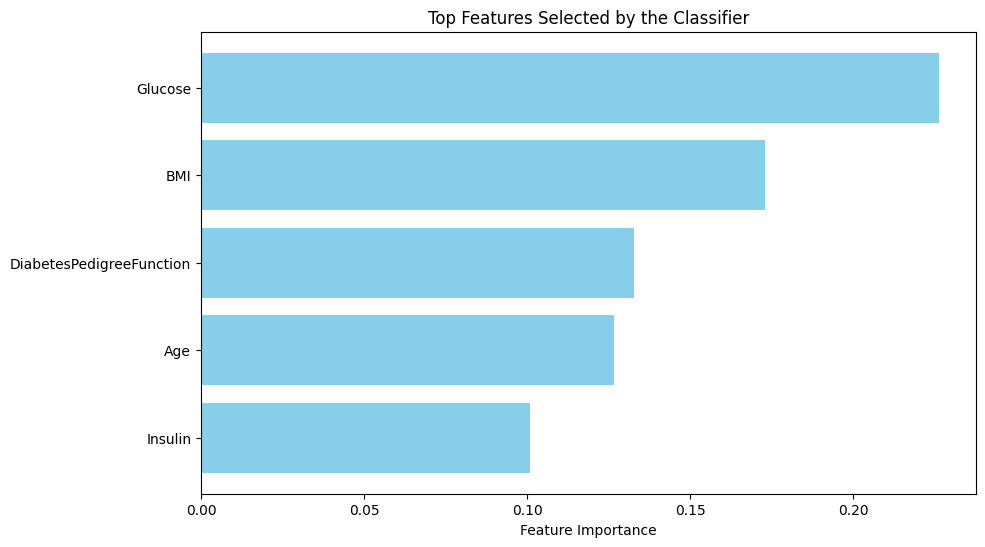

[1, 4, 5, 6, 7]

In [ ]:
SequentialFeatureSelectionWarpper(RandomForestClassifier(), 5, x_train, y_train, forward=True)

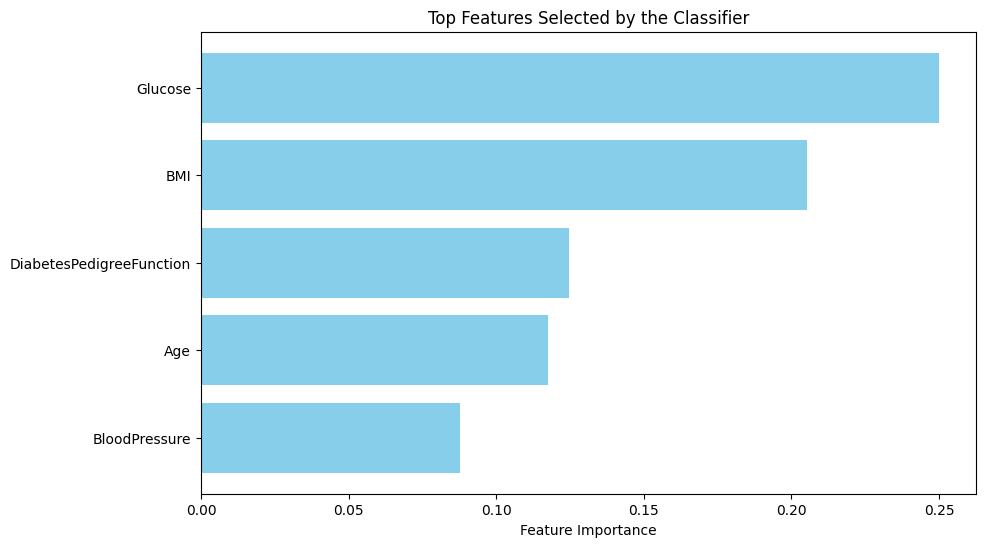

[1, 2, 3, 4, 6]

In [ ]:
SequentialFeatureSelectionWarpper(DecisionTreeClassifier(), 5, x_train, y_train, forward=True)

In [ ]:
def SequentialFeatureSelectionWarpper(classifiers, k_features, x_train, y_train, scoring="roc_auc", forward=True):
    selected_features_all = []

    fig, axs = plt.subplots(1, len(classifiers), figsize=(15, 6))

    for i, classifier in enumerate(classifiers):
        # Feature selection
        model_wrapper = SequentialFeatureSelector(classifier, k_features, scoring=scoring, forward=forward)
        mymodel = model_wrapper.fit(x_train, y_train)
        selected_features_idx = list(mymodel.k_feature_idx_)
        selected_features_all.append(selected_features_idx)

        # Get feature names
        feature_names = x_train.columns

        # Visualizing feature importance
        feature_importance = classifier.fit(x_train, y_train).feature_importances_
        sorted_idx = feature_importance.argsort()[::-1]
        top_k_idx = sorted_idx[:k_features]
        top_k_features = [feature_names[idx] for idx in top_k_idx]
        top_k_importance = feature_importance[top_k_idx]

        axs[i].barh(top_k_features, top_k_importance, color='skyblue')
        axs[i].set_xlabel('Feature Importance')
        axs[i].set_title(f'{type(classifier).__name__} - Top Features Selected')
        axs[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

    return selected_features_all

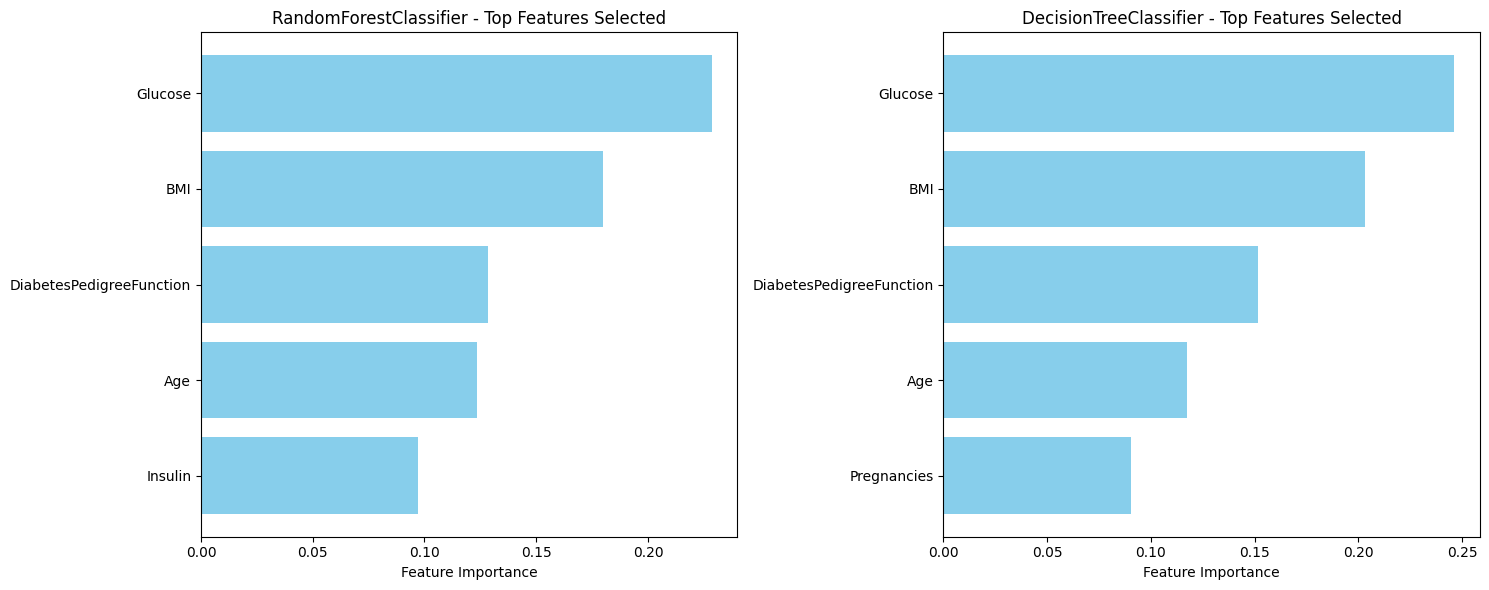

In [ ]:
# Sequential Forward Feature Selection
classifiers = [RandomForestClassifier(), DecisionTreeClassifier()]
selected_features = SequentialFeatureSelectionWarpper(classifiers, 5, x_train, y_train)

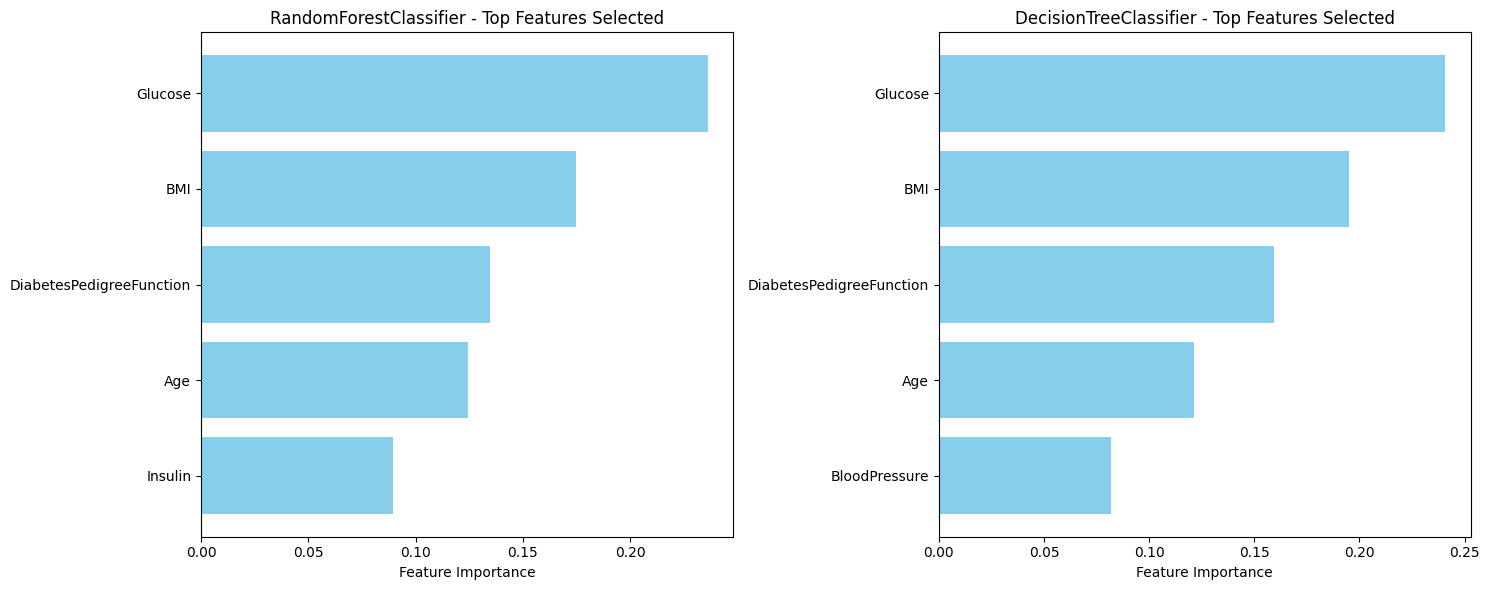

In [ ]:
# Sequential Backward Feature Selection
classifiers = [RandomForestClassifier(), DecisionTreeClassifier()]
selected_features = SequentialFeatureSelectionWarpper(classifiers, 5, x_train, y_train, forward=False)

# Sequential Floating Feature Selection

Sequential floating feature selection (SFFS) is a feature selection technique that iteratively builds feature subsets by adding or removing features based on their impact on model performance. Unlike sequential forward or backward selection, SFFS allows for both addition and removal of features during each iteration, aiming to find the most relevant subset of features for the model. This method iteratively evaluates different combinations of features to determine the optimal subset that maximizes model performance.

In [ ]:
def SequentialFloatingFeatureSelectionWarpper(classifiers, k_features, x_train, y_train, scoring="roc_auc", forward=True, floating=True):
    selected_features_all = []

    fig, axs = plt.subplots(1, len(classifiers), figsize=(15, 6))

    for i, classifier in enumerate(classifiers):
        # Feature selection
        model_wrapper = SequentialFeatureSelector(classifier, k_features, scoring=scoring, forward=forward, floating=floating)
        mymodel = model_wrapper.fit(x_train, y_train)
        selected_features_idx = list(mymodel.k_feature_idx_)
        selected_features_all.append(selected_features_idx)

        # Get feature names
        feature_names = x_train.columns

        # Visualizing feature importance
        feature_importance = classifier.fit(x_train, y_train).feature_importances_
        sorted_idx = feature_importance.argsort()[::-1]
        top_k_idx = sorted_idx[:k_features]
        top_k_features = [feature_names[idx] for idx in top_k_idx]
        top_k_importance = feature_importance[top_k_idx]

        axs[i].barh(top_k_features, top_k_importance, color='skyblue')
        axs[i].set_xlabel('Feature Importance')
        axs[i].set_title(f'{type(classifier).__name__} - Top Features Selected')
        axs[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

    return selected_features_all

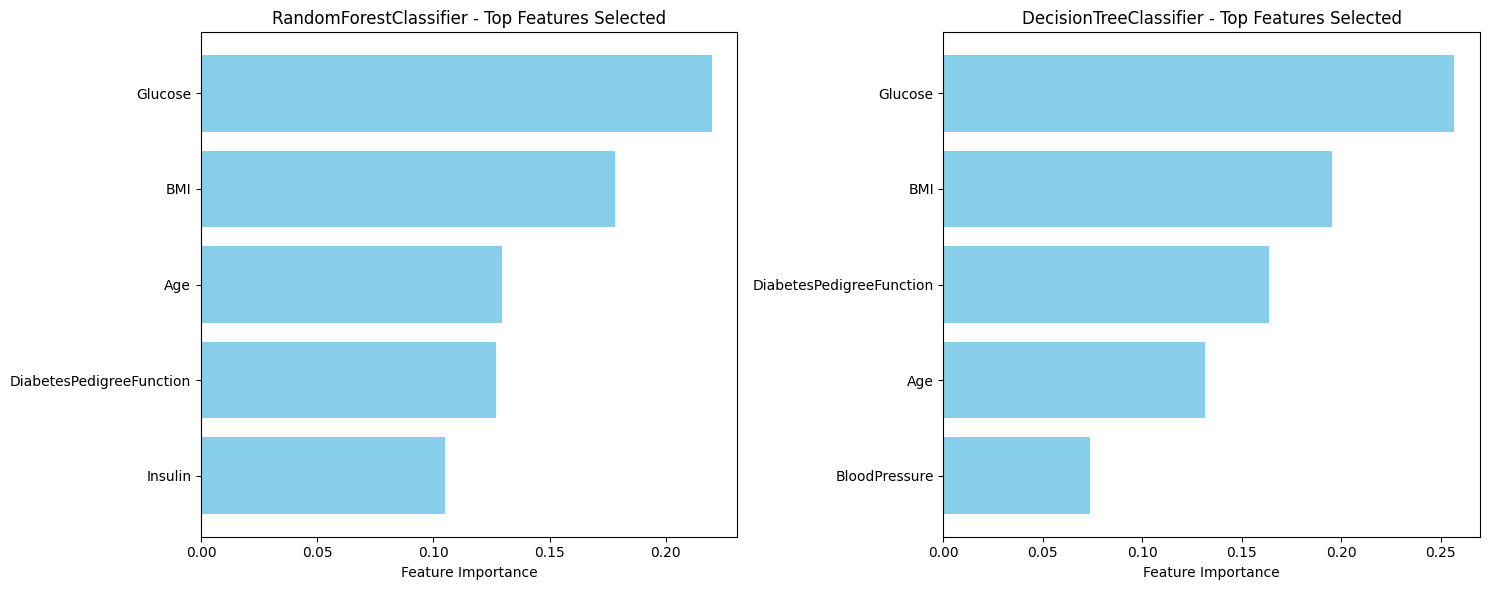

In [ ]:
# Sequential Floating Forward Feature Selection
classifiers = [RandomForestClassifier(), DecisionTreeClassifier()]
selected_features = SequentialFloatingFeatureSelectionWarpper(classifiers, 5, x_train, y_train)

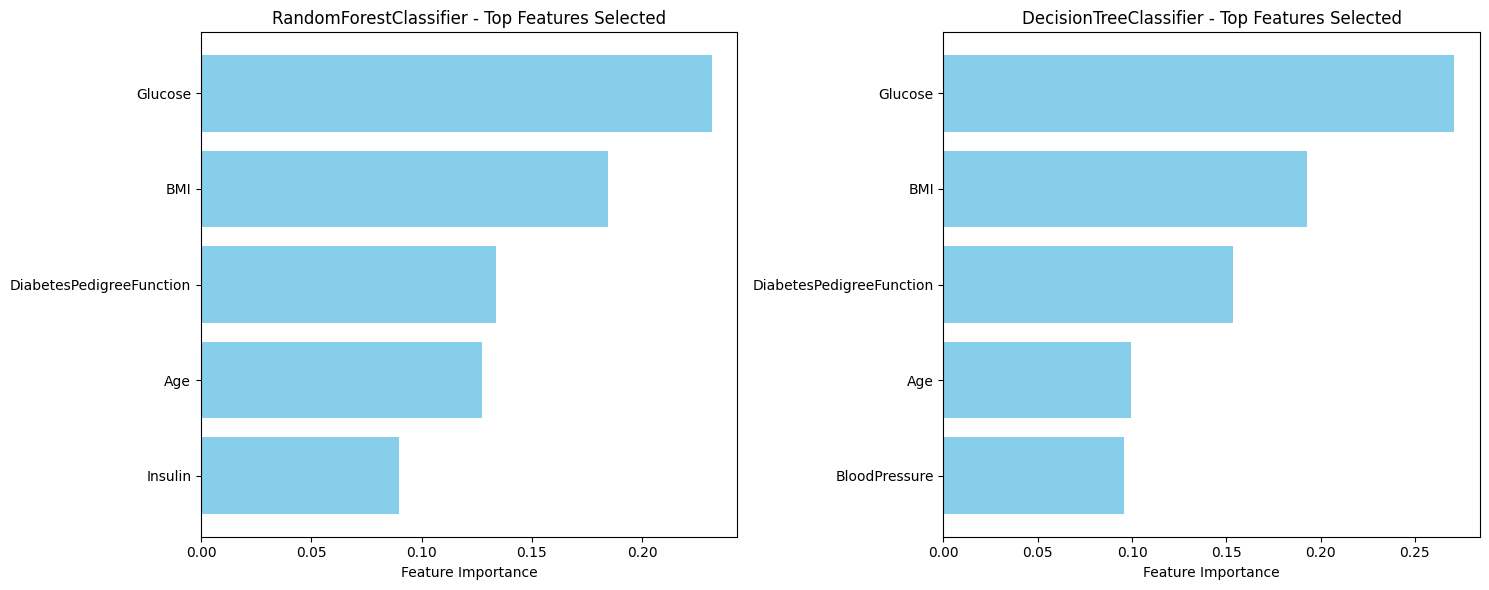

In [ ]:
# Sequential Floating Backward Feature Selection
classifiers = [RandomForestClassifier(), DecisionTreeClassifier()]
selected_features = SequentialFloatingFeatureSelectionWarpper(classifiers, 5, x_train, y_train, forward=False)

# Exhaustive Feature Selction

Exhaustive feature selection is a feature selection technique that evaluates all possible feature combinations directly to determine the best feature subset. This method generates subsets of all features in the dataset and evaluates the performance of each subset, thereby selecting the most suitable feature set.

In [ ]:
modelWrapperExhaustive = ExhaustiveFeatureSelector(RandomForestClassifier(), min_features =1, max_features=4)
model = modelWrapperExhaustive.fit(x_train, y_train)
list(model.best_idx_)

Features: 162/162

[0, 1, 3, 5]

In [ ]:
list(model.best_idx_)

[0, 1, 3, 5]

In [ ]:
def ExhaustiveFeatureSelectionWrapper(classifiers, x_train, y_train, scoring="roc_auc", min_features=1, max_features=4):
    selected_features_all = []

    fig, axs = plt.subplots(1, len(classifiers), figsize=(15, 6))

    for i, classifier in enumerate(classifiers):
        # Feature selection
        model_wrapper = ExhaustiveFeatureSelector(classifier, scoring=scoring, min_features=min_features, max_features=max_features)
        mymodel = model_wrapper.fit(x_train, y_train)
        selected_features_idx = list(mymodel.best_idx_)
        selected_features_all.append(selected_features_idx)

        # Get feature names
        feature_names = x_train.columns

        # Visualizing feature importance
        feature_importance = classifier.fit(x_train, y_train).feature_importances_
        sorted_idx = feature_importance.argsort()[::-1]
        top_k_idx = sorted_idx[:max_features]
        top_k_features = [feature_names[idx] for idx in top_k_idx]
        top_k_importance = feature_importance[top_k_idx]

        axs[i].barh(top_k_features, top_k_importance, color='skyblue')
        axs[i].set_xlabel('Feature Importance')
        axs[i].set_title(f'{type(classifier).__name__} - Top Features Selected')
        axs[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

    return selected_features_all


Features: 218/218

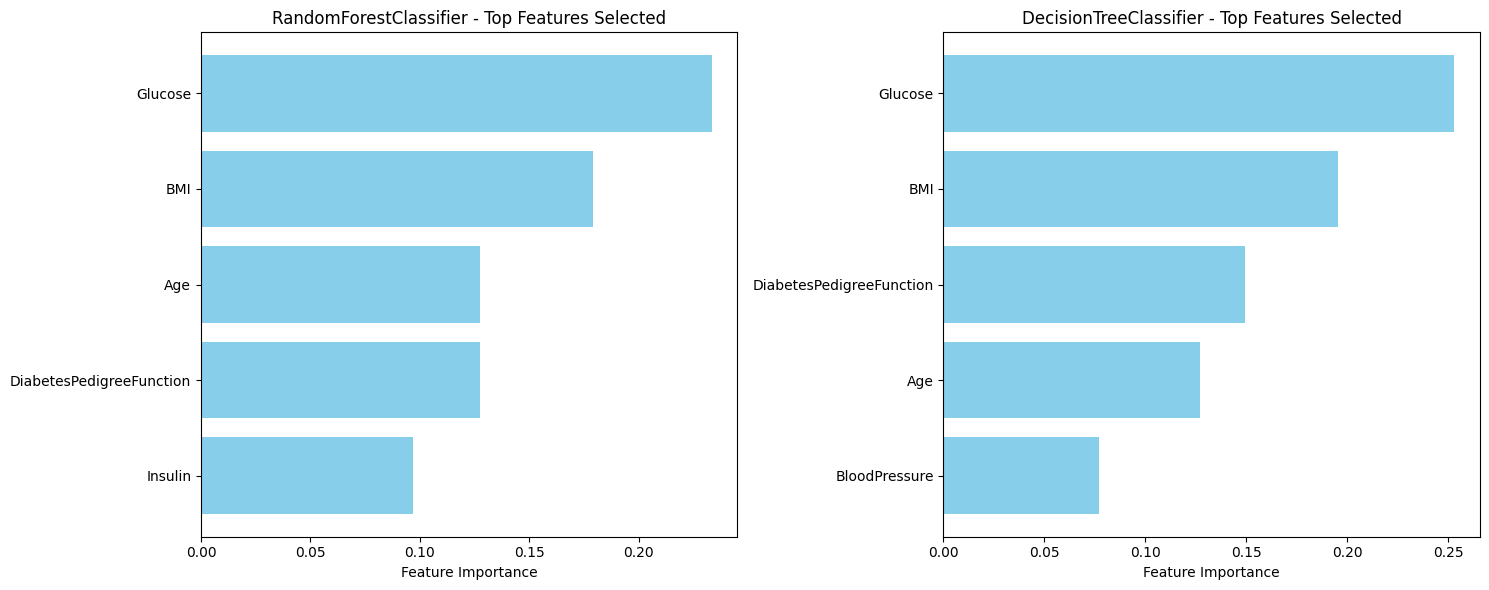

[[0, 1, 5, 6, 7], [1, 2, 4, 5, 7]]

In [ ]:
# Exhaustive Feature Selction
classifiers = [RandomForestClassifier(), DecisionTreeClassifier()]
ExhaustiveFeatureSelectionWrapper(classifiers, x_train, y_train, min_features=1, max_features=5)